In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate, scipy.signal
from functions import *

In [2]:
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.0,0.0,NaN,NaN
1,10,0,NaN,NaN,0.0,-100.0
2,20,0,0.0,0.0,NaN,NaN
3,5,10,NaN,NaN,0.0,0.0
4,15,10,NaN,NaN,0.0,0.0


In [3]:
elements

,start_node,end_node,area,Youngs_modulus,density
0,0,1,0.000002,1.000000e+10,2700
1,1,2,0.000002,1.000000e+10,2700
2,0,3,0.000002,1.000000e+10,2700
3,1,3,0.000002,1.000000e+10,2700
4,1,4,0.000002,1.000000e+10,2700
5,4,2,0.000002,1.000000e+10,2700
6,3,4,0.000002,1.000000e+10,2700


In [4]:
elements[['length', 'stiffness_matrix']] = elements.apply(element_stiffness, axis=1, result_type='expand')
elements['mass_matrix'] = elements.apply(element_mass, axis=1)
elements

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
3,1,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
4,1,4,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
5,4,2,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
6,3,4,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [5]:
K = elements.apply(global_stiffness, axis=1).sum()
M = elements.apply(global_mass, axis=1).sum()

In [6]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition(K, A, B)
MAA, MAB, MBA, MBB = partition(M, A, B)

In [7]:
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA),(PA-np.dot(KAB,UB)))
U[A] = UA
PB = np.dot(KBA,UA)+np.dot(KBB,UB)
P[B] = PB

result = nodes.copy()
result[['displacement_x', 'displacement_y']] = U.reshape(-1,2)
result[['load_x', 'load_y']] = P.reshape(-1,2)
result

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000000e+00,0.000000,25.0,50.0
1,10,0,3.517113e-19,-0.082377,0.0,-100.0
2,20,0,0.000000e+00,0.000000,-25.0,50.0
3,5,10,1.250000e-02,-0.041189,0.0,0.0
4,15,10,-1.250000e-02,-0.041189,0.0,0.0


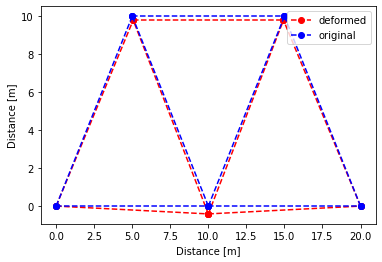

In [8]:
factor = 5
result['deformed_x'] = result['coordinate_x'] + factor*result['displacement_x']
result['deformed_y'] = result['coordinate_y'] + factor*result['displacement_y']

connectpoints(result['deformed_x'], result['deformed_y'],0,1,True,True)
connectpoints(result['deformed_x'], result['deformed_y'],1,2)
connectpoints(result['deformed_x'], result['deformed_y'],0,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,4)
connectpoints(result['deformed_x'], result['deformed_y'],2,4)
connectpoints(result['deformed_x'], result['deformed_y'],3,4)

connectpoints(result['coordinate_x'], result['coordinate_y'],0,1,False,True)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,2,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],0,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],2,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],3,4,False)

plt.xlabel("Distance [m]")
plt.ylabel("Distance [m]")

plt.legend()
plt.show()

In [9]:
frequencies, modes = modal_analysis(MAA, KAA)

In [10]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

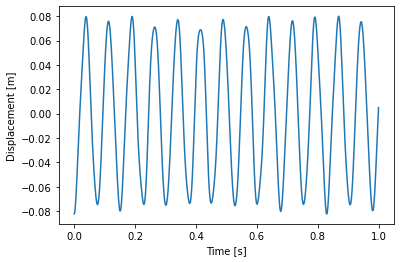

In [11]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [12]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), d)

d, d_dot, v, v_dot = Alpha(MAA, KAA, d, d_dot, v, v_dot, dt, t)

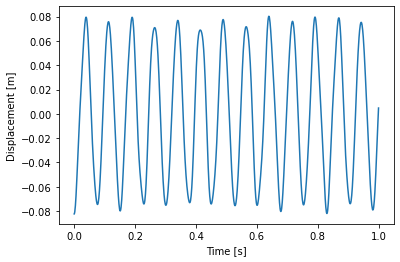

In [13]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [14]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta(MAA, KAA, T_range, x_0)

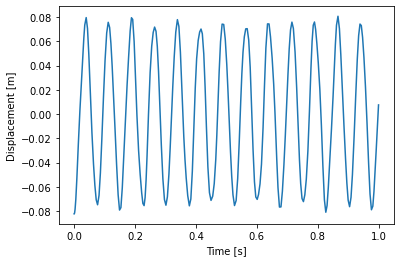

In [15]:
plt.plot(time, x[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

Text(0, 0.5, 'Displacement [m]')

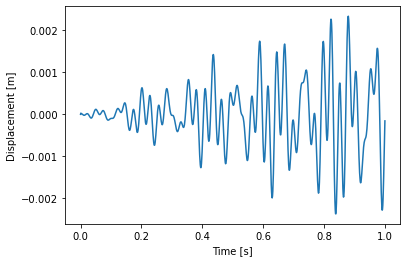

In [16]:
plt.plot(np.linspace(0, T*deltaT, T), d[1,:]-a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [17]:
mse = 0
for i in range(len(a[1,:])):
    mse += (a[1,i]-d[1,i])**2
print(np.sqrt(mse))    

0.02452218099352729


In [18]:
CAA, damping_factors = damping_factors(frequencies, frequencies[0], frequencies[1], 0.05, 0.05, MAA, KAA)

In [19]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta_damping(MAA, CAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

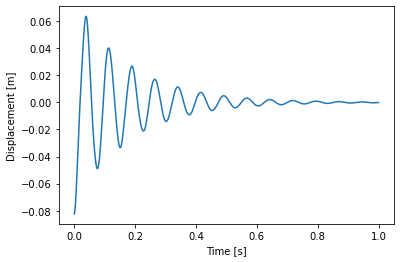

In [20]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [21]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, d_dot)-np.dot(KAA, d))

d, d_dot, v, v_dot = Alpha_damping(MAA, CAA, KAA, d, d_dot, v, v_dot, dt, t)

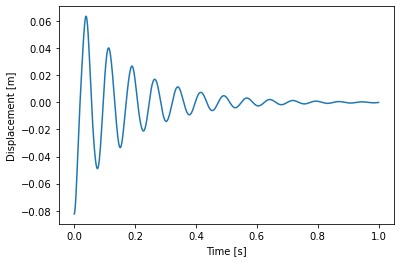

In [22]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [23]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta_damping(MAA, CAA, KAA, T_range, x_0)

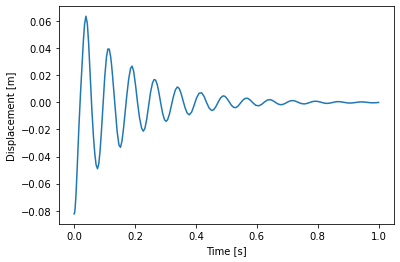

In [24]:
plt.plot(time, x[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

Text(0, 0.5, 'Displacement [m]')

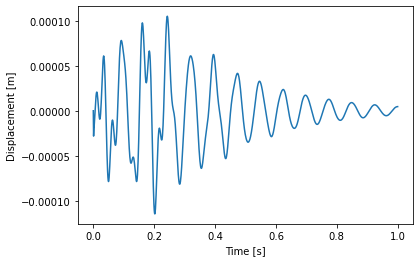

In [25]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:]-d[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [26]:
mse = 0
for i in range(len(a[1,:])):
    mse += (a[1,i]-d[1,i])**2
print(np.sqrt(mse))  

0.0011102652714073257


In [27]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)

Text(0, 0.5, 'Displacement [m]')

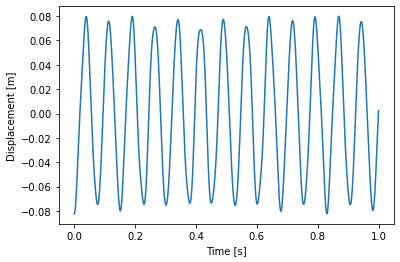

In [28]:
a = np.zeros((3*len(UA),1))
a[0:6,0] = np.transpose(UA)
for i in range(T-1):
  a_new = np.dot(A, a[:,i])
  a = np.append(a, a_new.reshape(3*len(UA),1), axis=1)

plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [29]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

In [30]:
data = generate_pseudo_data(a, T, 0.2)

Text(0, 0.5, 'Displacement [m]')

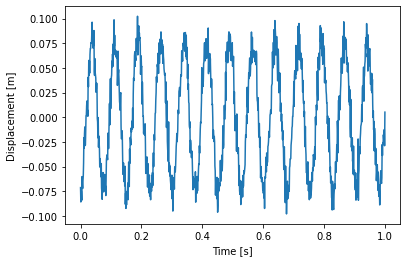

In [31]:
plt.plot(np.linspace(0, T*deltaT, T), data[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [32]:
H = observe_displacements(A)

In [33]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data, 1, 1, 1, T)

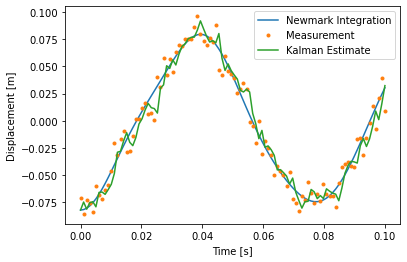

In [34]:
scale = 0.1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[1,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[1,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[1,:int(T*scale)], label='Kalman Estimate')
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [35]:
elements2[['length', 'stiffness_matrix']] = elements2.apply(element_stiffness, axis=1, result_type='expand')
elements2['mass_matrix'] = elements2.apply(element_mass, axis=1)
elements2

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
3,1,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
4,1,4,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
5,4,2,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
6,3,4,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [36]:
K2 = elements2.apply(global_stiffness, axis=1).sum()
M2 = elements2.apply(global_mass, axis=1).sum()

In [37]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)
KAA2, KAB2, KBA2, KBB2 = partition(K2, A, B)
MAA2, MAB2, MBA2, MBB2 = partition(M2, A, B)
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA2),(PA-np.dot(KAB2,UB)))
U[A] = UA
PB = np.dot(KBA2,UA)+np.dot(KBB2,UB)
P[B] = PB

In [38]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
A2 = transition_matrix_Newmark_Beta(MAA2, KAA2, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)
B2 = force_matrix_Newmark_Beta(MAA2, KAA2, deltaT)

In [39]:
a2 = np.zeros((len(UA),1))
a2[:,0] = np.transpose(UA)
a2_dot = np.zeros((len(UA),1))
a2_ddot = np.dot(np.linalg.inv(MAA2), np.dot(KAA2, a2))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a2, a2_dot, a2_ddot = Newmark_Beta(MAA2, KAA2, f, a2, a2_dot, a2_ddot, deltaT, T)
data2 = generate_pseudo_data(a2, T, 0.2)

In [40]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data2, 1, 0.2*np.std(a), 0.05*np.mean(np.abs(a)), T)

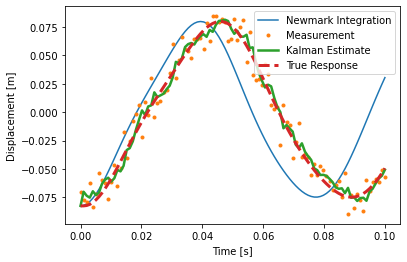

In [41]:
scale = 0.1
index = 1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[index,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data2[index,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[index,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a2[index,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [42]:
def Kalman_filter_aug(A, B, H, x, force_func, y, sigma_0, sigma_r, sigma_q, sigma_epsilon, T):
  Q = sigma_q*np.identity(np.shape(A)[0])
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_0*np.identity(np.shape(A)[0])]

  energy = 0

  for i in range(T-1):
    f = force_func(x[-1,i],T)
    x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
    P_predict = np.dot(A, np.dot(P[i], np.transpose(A))) + Q
    V = y[:,i] - np.dot(H, x_predict)
    S = np.dot(H, np.dot(P_predict, np.transpose(H))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(S, np.transpose(K)))
    x_estimate[-1] += np.random.normal(0, sigma_epsilon)

    x = np.append(x, x_estimate.reshape(np.shape(A)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy

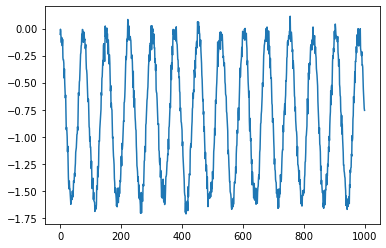

In [57]:
T = 1000
f = constant_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
data = generate_pseudo_data(a, T, 0.1)
plt.plot(data[1,:])

In [44]:
param = [-400]
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
A_aug, B_aug, H_aug = aug_lin_model(A, B, H, x, param)

In [45]:
aug_state = np.vstack((x,param))

In [46]:
aug_state, energy = Kalman_filter_aug(A_aug, B_aug, H_aug, aug_state, constant_force, data, 1, 0.01, 1000, 2, T)

-400.05356456905014


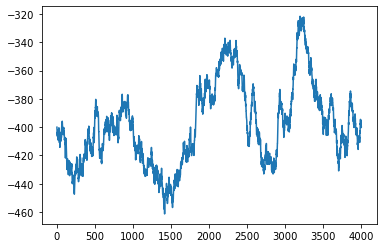

In [47]:
plt.plot(aug_state[18,:])
# plt.plot(data[1,:])
print(aug_state[-1,-1])

In [146]:
def random_force(param, T):
  return np.random.normal(param, 50, (6,T))

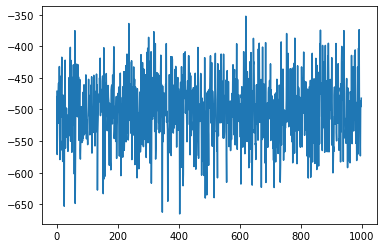

In [147]:
f = random_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

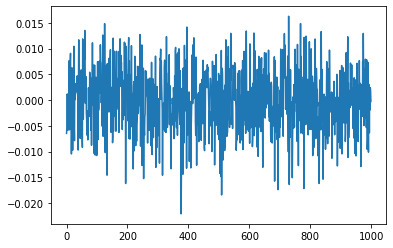

In [148]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(data[1,:]-a[1,:])

In [149]:
sigma_r = 0.01*np.std(a)
print(sigma_r)
sigma_q = np.mean(np.abs(a))
print(sigma_q)

0.005333091090542827
0.654002823303004


100%|██████████| 999/999 [02:31<00:00,  6.61it/s]

-504.6854137909639
0.921


Text(0, 0.5, 'Parameter Posterior')

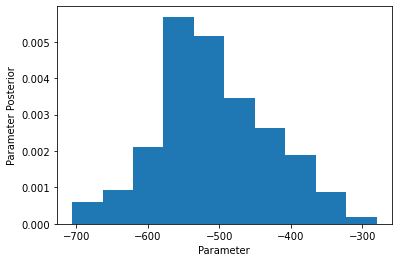

In [157]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
N = 1000
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, random_force, data, 1, sigma_r, 100*sigma_q, -400, 100, 0.2, T, N, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

-504.6854137909639
-507.7090020975044


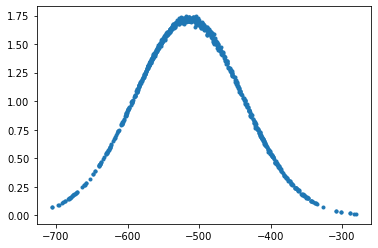

In [158]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])
print(np.mean(param))

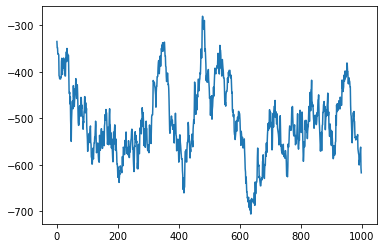

In [159]:
plt.plot(param)

In [55]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
N = 1000
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, 0.05, 1, -400, 100, 0.2, T, N, 'pcn')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

  1%|          | 12/999 [00:10<14:38,  1.12it/s]


KeyboardInterrupt: 

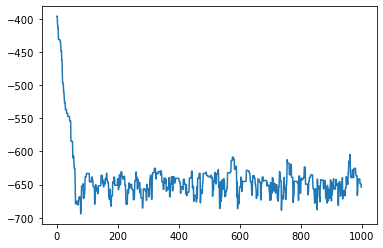

In [ ]:
plt.plot(param)

(array([0.00493443, 0.01480329, 0.01151367, 0.02138253, 0.02631696,
        0.03125139, 0.01480329, 0.01480329, 0.00328962, 0.00493443]),
 array([-679.67172301, -672.91646885, -666.1612147 , -659.40596055,
        -652.6507064 , -645.89545224, -639.14019809, -632.38494394,
        -625.62968979, -618.87443563, -612.11918148]),
 <BarContainer object of 10 artists>)

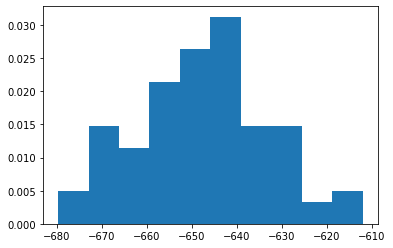

In [ ]:
param_subsampled = param[100::10]
plt.hist(param_subsampled, density=True)

100%|██████████| 999/999 [02:04<00:00,  8.01it/s]

-659.239567177344
0.612


Text(0, 0.5, 'Parameter Posterior')

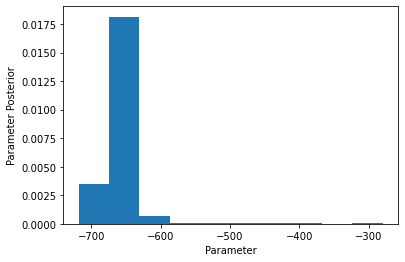

In [ ]:
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, 0.05, 1, -400, 100, 0.2, T, N, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

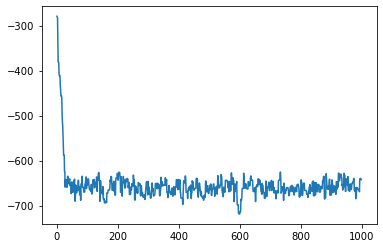

In [ ]:
plt.plot(param)

(array([0.00131075, 0.        , 0.00131075, 0.00131075, 0.00786447,
        0.02097192, 0.02752565, 0.02359341, 0.01966118, 0.0144182 ]),
 array([-718.55839373, -710.08145178, -701.60450984, -693.12756789,
        -684.65062594, -676.173684  , -667.69674205, -659.21980011,
        -650.74285816, -642.26591622, -633.78897427]),
 <BarContainer object of 10 artists>)

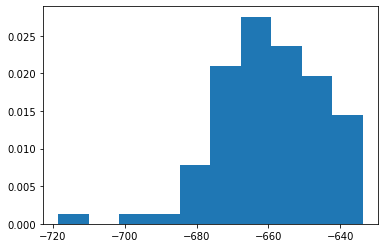

In [ ]:
param_subsampled = param[100::10]
plt.hist(param_subsampled, density=True)

100%|██████████| 999/999 [02:11<00:00,  7.62it/s]

-667.2354861198945
0.566


Text(0, 0.5, 'Parameter Posterior')

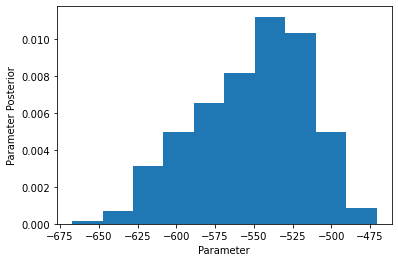

In [ ]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
N = 1000
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, 0.05, 10, -400, 100, 0.2, T, N, 'pcn')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

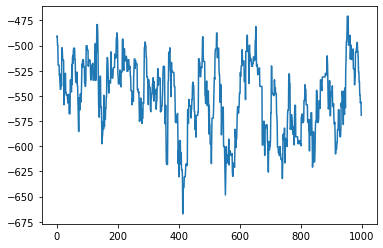

In [ ]:
plt.plot(param)

(array([0.00326624, 0.00489936, 0.00489936, 0.00571592, 0.01061529,
        0.00898217, 0.01061529, 0.00898217, 0.00489936, 0.01061529]),
 array([-632.16067028, -618.55346193, -604.94625359, -591.33904524,
        -577.7318369 , -564.12462855, -550.51742021, -536.91021187,
        -523.30300352, -509.69579518, -496.08858683]),
 <BarContainer object of 10 artists>)

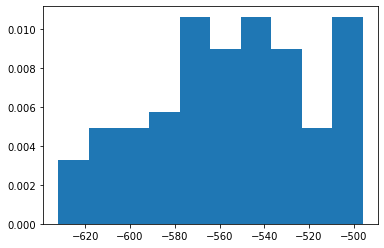

In [ ]:
param_subsampled = param[100::10]
plt.hist(param_subsampled, density=True)

100%|██████████| 999/999 [02:04<00:00,  8.01it/s]

-620.0726170270128
0.849


Text(0, 0.5, 'Parameter Posterior')

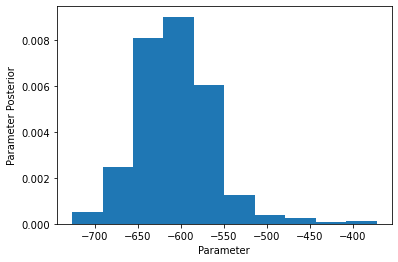

In [ ]:
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, 0.05, 10, -400, 100, 0.2, T, N, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

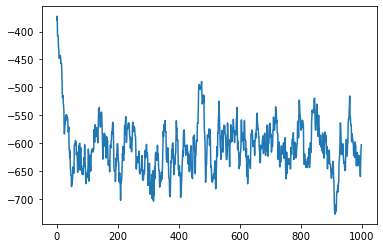

In [ ]:
plt.plot(param)

(array([0.00172078, 0.00229438, 0.00630954, 0.00688314, 0.0108983 ,
        0.00860392, 0.00975111, 0.00286797, 0.00114719, 0.00114719]),
 array([-697.3306713 , -677.95966072, -658.58865014, -639.21763957,
        -619.84662899, -600.47561842, -581.10460784, -561.73359727,
        -542.36258669, -522.99157611, -503.62056554]),
 <BarContainer object of 10 artists>)

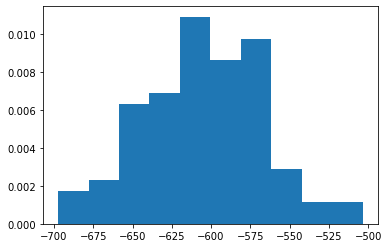

In [ ]:
param_subsampled = param[100::10]
plt.hist(param_subsampled, density=True)

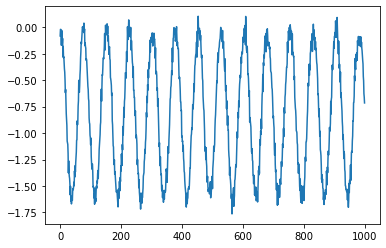

In [ ]:
x_MC = np.zeros(N)
for i in range(N):
    x_MC += X[i][1,:]
plt.plot(x_MC/N)

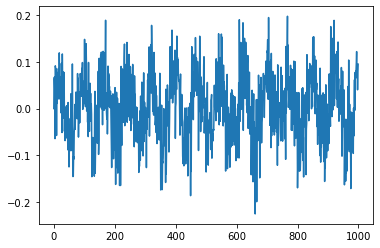

In [ ]:
plt.plot(x_MC/N-a[1,:])

In [ ]:
diff = 0
for i in range(len(a[1,:])):
    diff += (x_MC[i]/N-a[1,i])**2
print(diff)

5.1351125870687735


In [ ]:
diff = 0
for i in range(len(a[1,:])):
    diff += (X[index][1,i]-a[1,i])**2
print(diff)

5.1346964096443335


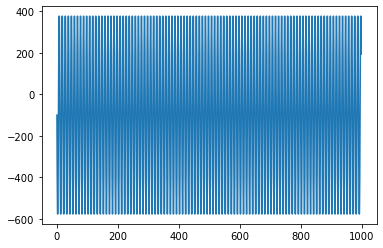

In [58]:
f = sinusoidal_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

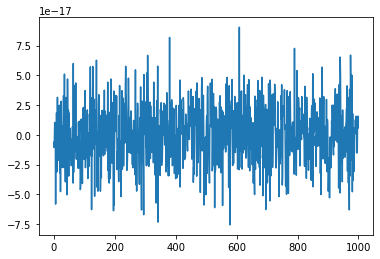

In [65]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(data[0,:]-a[0,:])

In [66]:
sigma_r = 0.01*np.std(a)
print(sigma_r)
sigma_q = np.mean(np.abs(a))
print(sigma_q)

0.00038780331075354625
0.03239051824923137


100%|██████████| 999/999 [02:29<00:00,  6.68it/s]


-516.8897575400612
0.852


Text(0, 0.5, 'Parameter Posterior')

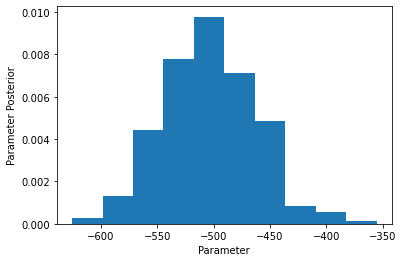

In [118]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, sinusoidal_force, data, 1, sigma_r, 0*sigma_q, -400, 100, 0.2, T, 1000, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

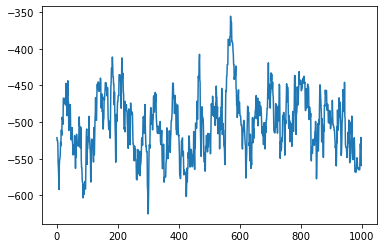

In [119]:
plt.plot(param)

-516.8897575400612


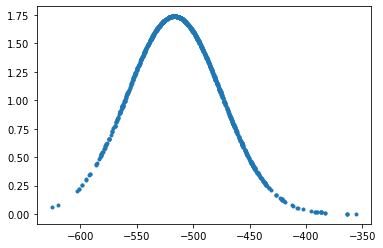

In [120]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

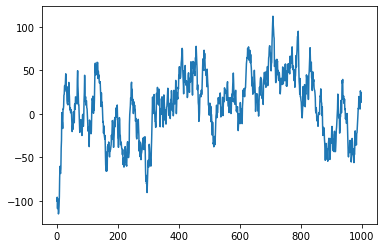

In [163]:
f = AR_1(0.95, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

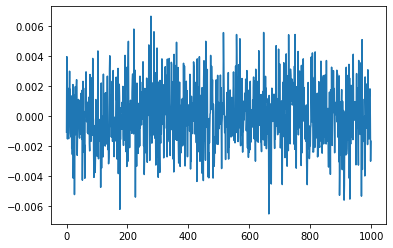

In [164]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(data[1,:]-a[1,:])

In [165]:
sigma_r = np.mean(np.abs(data-a))
print(sigma_r)
sigma_q = np.mean(np.abs(a))
print(sigma_q)

0.001088466031555585
0.1157104176144457


100%|██████████| 999/999 [02:46<00:00,  6.00it/s]


0.933488836545926
0.019


Text(0, 0.5, 'Parameter Posterior')

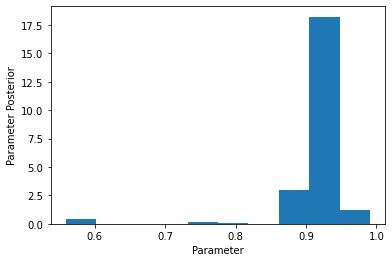

In [256]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, AR_1, data, 1, sigma_r, 0.1*sigma_q, 0.5, 0.6, 0.2, T, 1000, 'pcn')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

0.933488836545926


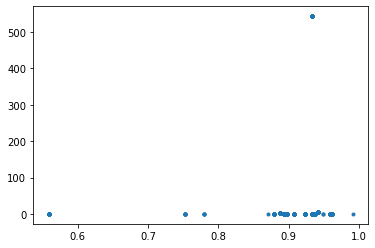

In [257]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

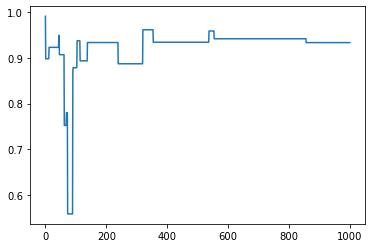

In [258]:
plt.plot(param)

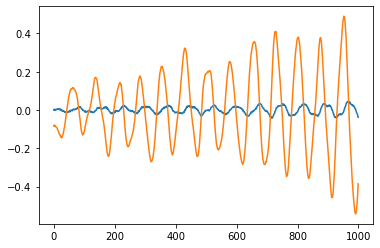

In [259]:
plt.plot(X[index][1,:]-a[1,:])
plt.plot(data[1,:])

In [260]:
diff = 0
for i in range(len(a[1,:])):
    diff += (X[index][1,i]-a[1,i])**2
print(diff)

0.30812670483918275


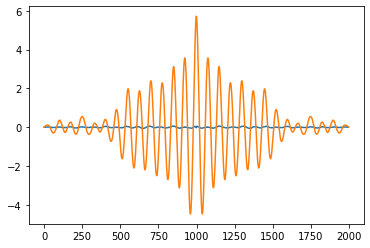

In [ ]:
autocorr = scipy.signal.correlate(X[index][1,:],X[index][1,:])
autocorr_true = scipy.signal.correlate(a[1,:],a[1,:])
plt.plot(autocorr_true-autocorr)
plt.plot(autocorr_true)

In [ ]:
def true_autocorr(param, T):
    scale = 100/(1-param**2)
    autocorr = []
    for i in range(-T,T):
        autocorr.append(scale*param**np.abs(i))
    return autocorr       

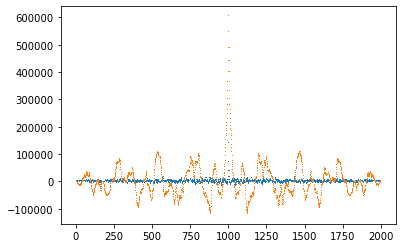

In [ ]:
force = AR_1(mean_MAP,T)
force_true = AR_1(0.9,T)
force_autocorr = scipy.signal.correlate(force[1,:],force[1,:])
force_autocorr_true = scipy.signal.correlate(force_true[1,:],force_true[1,:])
true_autocor = true_autocorr(0.9,T)
# plt.plot(true_autocor, ',')
plt.plot(force_autocorr, ',')
plt.plot(force_autocorr_true, ',')